# Notebook with SCI subjects included
### includes resampling of clips to equalize number of samples across subjects
This strategy improves results for the hamstring but not for the Gastrocnemius

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import itertools
from collections import defaultdict

import math
import nolds

#XGBoost now needs path to runtime compilers
import os
# mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.1.0-posix-seh-rt_v5-rev0\\mingw64\\bin'
# os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
# import xgboost as xgb
# from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper

from sklearn.model_selection import LeaveOneGroupOut
from sklearn import preprocessing
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score


path = '../Datasets/Spasticity/LabeledData/'
savepath = '../Datasets/Spasticity/'
sns.set_context('talk',font_scale=1)

In [2]:
current_palette = sns.color_palette()

def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if plotname=='Threshold':
        ls = '--'
    else:
        ls='-'
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=3,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=3,linestyle=ls)
             
    lw = 3
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right')
    
    return ax

In [3]:
def getFeatures(EMGSignal):
    
    EPS = .0001
    
    Feat = {}
    Feat['MeanAbsValue'] = np.mean(np.abs(EMGSignal))
    
    PosInds = EMGSignal>0
    Feat['ZeroCrossings'] = sum((PosInds[1:len(PosInds)] != PosInds[0:(len(PosInds)-1)]) & (np.abs(np.diff(EMGSignal))>EPS))
    
    DiffEMGSignal = np.diff(EMGSignal)
    PosInds = DiffEMGSignal>0
    Feat['SlopeZeroCrossings'] = sum((PosInds[1:len(PosInds)] != PosInds[0:(len(PosInds)-1)]) & 
                                     (np.abs(np.diff(DiffEMGSignal))>EPS))
    
    Feat['WaveformLength'] = np.mean(np.abs(EMGSignal[1:len(EMGSignal)-1]-EMGSignal[2:len(EMGSignal)]))
    
    Feat['WillisonAmplitude'] = sum(np.abs(EMGSignal[1:len(EMGSignal)-1]-EMGSignal[2:len(EMGSignal)])>EPS)
    
    Feat['RMS'] = math.sqrt(np.mean(np.square(EMGSignal)))
    
    Feat['Variance'] = np.var(EMGSignal)
    
    
    FFTPow = np.square(np.abs(np.fft.rfft(EMGSignal)))
    for i, key in enumerate(['FFT:0-20Hz', 'FFT:20-40Hz', 'FFT:40-60Hz', 'FFT:60-80Hz', 'FFT:80-100Hz', 'FFT:100-120Hz']):
        Feat[key] = np.sum(FFTPow[1+int(len(FFTPow)/6 * i):int(len(FFTPow)/6 * (i+1))])
    # TODO: Sample Entropy and FFT
    
    Feat['SampEn'] = nolds.sampen(EMGSignal)
    Feat['FFT:SampEn'] = nolds.sampen(FFTPow)
    
    return Feat

In [4]:
def getClips(EMGSignal, winsize, overlap):
    Clips = []
    Features = defaultdict(list)
    for indStart in range(0,int(len(EMGSignal)-winsize),int(winsize*(1-overlap))):
        Clip = np.asarray(EMGSignal[indStart:indStart+125])
        Feat = getFeatures(Clip)
        Clips.append(Clip)
        for key in Feat:
            Features[key].append(Feat[key])
        
    return Clips, Features

In [84]:
#fit base-level and meta-level classifier 
def fit_stacking(X_train,y_train,groups): 
    
    base_classifiers = [];     meta_classifier = []
    subj = LeaveOneGroupOut()

    Xtrain_meta = np.zeros((len(y_train),len(models))) #stores the meta-level classifier features (posterior of each base-level classifier)
    ytrain_meta = np.array([]) #stores the labels to train meta-classifier
    i = 0 #counter for current classifier trained

    #CV to train base level clf and obtain train features for meta-level
    for clf,name in zip(models,model_name):

        print(name)
        yscoreCV = np.array([])  #stores the posterior prob of each base-level clf

        #CV to obtain posteriors from each clf (meta-features)
        for train, test in subj.split(X_train, y_train, groups):
            clf.fit(X_train[train,:],y_train[train])
            yscore = clf.predict_proba(X_train[test,:]) 
            yscore = yscore[:,1]
            yscoreCV = np.append(yscoreCV,yscore) #concatenate scores for each fold
            if i == 0:
                #store labels to train metaclassifier ()
                ytrain_meta = np.append(ytrain_meta,y_train[test])

        Xtrain_meta[:,i] = yscoreCV #store the posterior of current clf
        i +=1

        #Train base level classifiers on all training data    
        clf.fit(X_train,y_train)
        base_classifiers.append(clf)
        
    print('base-level classifiers trained')
        
    #add extra meta-features 
    metastd = np.std(Xtrain_meta,axis=1)
    metastd = np.expand_dims(metastd,axis=0)
    Xtrain_meta = np.concatenate((Xtrain_meta,metastd.T),axis=1)
    
    #train meta-level classifier on posteriors (this needs another CV to optimize parameters)
    meta_scaler = preprocessing.StandardScaler().fit(Xtrain_meta)
    Xtrain_meta = meta_scaler.transform(Xtrain_meta)
    print('training meta-classifier')
    metaclf = LogisticRegression(C=.1)
#     metaclf = GradientBoostingClassifier(n_estimators=100,max_depth=2,random_state=3)
    metaclf.fit(np.concatenate((Xtrain_meta,X_train),axis=1),ytrain_meta)
    ypred_meta = metaclf.predict_proba(np.concatenate((Xtrain_meta,X_train),axis=1))
#     ind = np.where(np.array(ypred_meta) != np.array(ytrain_meta))
#     print Xtrain_meta[:10,:]
#     plt.figure(figsize=(12,8))
#     sns.heatmap(Xtrain_meta[ind,:])

    meta_classifier.append(metaclf)

    return base_classifiers, meta_classifier[0], meta_scaler

In [6]:
def predict_stacking(X_test,y_test,base_classifiers,meta_classifier,meta_scaler):
    
    Xtest_meta = np.zeros((len(y_test),len(base_classifiers))) #stores the base clf predictions for current subj
    auc_base = np.empty( (len(models),1) ) #store auc for each base classifier
    i = 0 #clf index

    #1. base-classifiers predictions
    for clf,name in zip(base_classifiers,model_name):
        Xtest_meta[:,i] = clf.predict_proba(X_test)[:,1]
        auc_base[i] = roc_auc_score(y_test, Xtest_meta[:,i])
        i+=1
    print('best base-clf %s, auc = %.3f, worst base-clf %s, minauc = %.3f' % (model_name[np.argmax(auc_base)],
                                                                       np.max(auc_base),
                                                                       model_name[np.argmin(auc_base)],
                                                                       np.min(auc_base)))

    #add extra meta features
    metastd = np.std(Xtest_meta,axis=1)
    metastd = np.expand_dims(metastd,axis=0)
    Xtest_meta = np.concatenate((Xtest_meta,metastd.T),axis=1)

    #2. meta-level clf predictions (final prediction)
    Xtest_meta = meta_scaler.transform(Xtest_meta)
    yscore_meta = meta_classifier.predict_proba(np.concatenate((Xtest_meta,X_test),axis=1))[:,1]
    ypred_meta = meta_classifier.predict(np.concatenate((Xtest_meta,X_test),axis=1))
    auc_meta = roc_auc_score(y_test, yscore_meta)
    print('auc meta = %.3f\n' % (auc_meta))

    return ypred_meta, yscore_meta

In [7]:
def LOSOCV(X,y,data,groups,models,stacking=1):

    TAUC_all=[]; Tfpr_all=[]; Ttpr_all=[]; TSens_all=[]; TSpec_all=[] #store results for each subject
    AUC_all=[]; fpr_all=[]; tpr_all=[]; Sens_all=[]; Spec_all=[]
    
    subj = LeaveOneGroupOut()
    subj.get_n_splits(X,y,groups)
    for train_index, test_index in subj.split(X, y, groups):
        
        Dtr = data.iloc[train_index]
        Dte = data.iloc[test_index] #the left out subject to test the classifier on
        
        #ML classifier
        if stacking == 0:
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            models.fit(Xtr,ytr)
            ypred = models.predict(Xte)
            yscore = models.predict_proba(Xte)
            yscore = yscore[:,1]
            
        else: #stacking - need a second round of CV on the train data set
            groups2 = Dtr.SubjID.as_matrix()
            Xtr = Dtr.iloc[:,0:14].as_matrix(); ytr = Dtr.Label
            Xte = Dte.iloc[:,0:14].as_matrix(); yte = Dte.Label
            Xtr = np.asarray(Xtr); ytr = np.asarray(ytr) #it took me 4hours to figure this line was needed!
            Xte = np.asarray(Xte); yte = np.asarray(yte) #it took me 4hours to figure this line was needed!
#             Xtr = scaler.transform(Xtr)
#             Xte = scaler.transform(Xte)
            base_classifiers, meta_classifier, meta_scaler = fit_stacking(Xtr,ytr,groups2) #train base and meta clf
            ypred, yscore = predict_stacking(Xte,yte,base_classifiers,meta_classifier,meta_scaler)

        #compute ROC at fixed fpr (to plot error bars)
        fpr=np.linspace(0,1,101); tpr=[]
        nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
        neg_counts = sum(yte==0)
        for f in fpr:
            ind = neg_counts-int(neg_counts*f)-1
            t = (nscores[ind])[0]
            if f==1:
                t = 0
            tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
            tpr.append(tpr_t) 

        fpr = np.asarray(fpr); tpr = np.asarray(tpr)
        roc_auc = auc(fpr, tpr)
        
        #compute Sens and Spec
        #randomforest
        ind = np.argmax(tpr-fpr)
        Sens = tpr[ind]
        Spec = 1-fpr[ind]
        
        AUC_all.append(roc_auc)
        tpr_all.append(tpr); fpr_all=fpr;
        Sens_all.append(Sens); Spec_all.append(Spec)

        print('AUC = %.4f, Sens = %.4f, Spec = %.4f\n'%(roc_auc,Sens,Spec)) #random forest
        

    #summary results
    print(('mean AUC = %.3f (+/- %0.3f)')%(np.mean(AUC_all),2*np.std(AUC_all)/np.sqrt(len(AUC_all))))
    print(('mean Sens = %.3f (+/- %0.3f)')%(np.mean(Sens_all),2*np.std(Sens_all)/np.sqrt(len(AUC_all))))
    print(('mean Spec = %.3f (+/- %0.3f)')%(np.mean(Spec_all),2*np.std(Spec_all)/np.sqrt(len(AUC_all))))

    results = {'AUC':AUC_all, 'TPR':tpr_all, 'FPR':fpr_all, 'Sens':Sens_all, 'Spec':Spec_all}
    return results

In [19]:
winsize = 1.5 * 250 # Test different values later (*250 to convert sec to samples)
overlap = .8 # 0-1; use value such that winsize*overlap is integer for now

RawDataClips = []
Features = defaultdict(list)
ClipLabels = []
SubjID = []
Location = []

for x in itertools.product(range(1,33),['Lab Day1','Lab Day2'],['Gastrocnemius', 'Hamstring'],['MAS', 'MVC', 'VCM']):
    if x[2]=='Hamstring':
        Act = 'KF'
    else:
        Act = 'PF'
    
    oldLen = len(RawDataClips)
    
    try:
        Data = pd.read_csv(path + 'CS' + str(x[0]).zfill(3) + '/' + x[1] + '/' + x[2] + '_' + x[3] + ' ' + Act + '_labeled.csv',
                          header = None)
        if x[2]=='Hamstring':
            Labind = 8
        else:
            Labind = 5
            
        EMGData = Data[4]
        Label = Data[Labind]
        
        for l in zip(['Spastic Activity', 'Non-Spastic Activity', 'Inactive'],['SA','HA','IA']):
            lab_old = l[0]
            lab_new = l[1]
            
            lab_inds = Label==lab_old
            lab_inds_diff = lab_inds[1:len(lab_inds)].values != lab_inds[0:len(lab_inds)-1].values
            
            # Get starts/ends of continuous labels
            cont_label_startend = [i+1 for i,xx in enumerate(lab_inds_diff) if xx]
            
            # Note: this assumes that the data stream begins and ends with unlabeled data
            # Even indices are starts, odds are ends
            for nLabel in range(0,len(cont_label_startend),2): 
                LabeledData = EMGData[cont_label_startend[nLabel]:cont_label_startend[nLabel+1]]
                
                newClips, newFeatures = getClips(LabeledData, winsize, overlap)
                
                RawDataClips += newClips
                for key in newFeatures:
                    Features[key] += newFeatures[key]
                SubjID += [x[0]] * len(newClips)
                ClipLabels += [lab_new]*len(newClips)
                Location += [x[2]]*len(newClips)
            
    except(OSError):
        print(path + 'CS' + str(x[0]).zfill(3) + '/' + x[1] + '/' + x[2] + '_' + x[3] + ' ' + Act + '_labeled.csv')
        

../Datasets/Spasticity/LabeledData/CS001/Lab Day2/Gastrocnemius_MAS PF_labeled.csv
../Datasets/Spasticity/LabeledData/CS001/Lab Day2/Gastrocnemius_MVC PF_labeled.csv
../Datasets/Spasticity/LabeledData/CS001/Lab Day2/Gastrocnemius_VCM PF_labeled.csv
../Datasets/Spasticity/LabeledData/CS001/Lab Day2/Hamstring_MAS KF_labeled.csv
../Datasets/Spasticity/LabeledData/CS001/Lab Day2/Hamstring_MVC KF_labeled.csv
../Datasets/Spasticity/LabeledData/CS001/Lab Day2/Hamstring_VCM KF_labeled.csv
../Datasets/Spasticity/LabeledData/CS002/Lab Day1/Gastrocnemius_MVC PF_labeled.csv
../Datasets/Spasticity/LabeledData/CS002/Lab Day1/Hamstring_VCM KF_labeled.csv
../Datasets/Spasticity/LabeledData/CS003/Lab Day2/Hamstring_VCM KF_labeled.csv
../Datasets/Spasticity/LabeledData/CS004/Lab Day1/Gastrocnemius_MVC PF_labeled.csv
../Datasets/Spasticity/LabeledData/CS004/Lab Day1/Gastrocnemius_VCM PF_labeled.csv
../Datasets/Spasticity/LabeledData/CS005/Lab Day2/Gastrocnemius_VCM PF_labeled.csv
../Datasets/Spasticity/L

In [20]:
FullData = pd.DataFrame(Features).assign(RawData=pd.Series(RawDataClips), SubjID=pd.Series(SubjID), Label=pd.Series(ClipLabels), Location=pd.Series(Location))

In [21]:
#save Clips Data
FullData.to_csv(path_or_buf=savepath+'Clips_ws'+str(winsize/250)+'_overlap'+str(overlap)+'.csv')

In [8]:
#Load Clips Data
# FullData = pd.read_csv(savepath+'Clips_ws0.5_overlap0.5.csv')
# FullData = pd.read_csv(savepath+'Clips_ws0.5_overlap0.8.csv')
# FullData = pd.read_csv(savepath+'Clips_ws1.0_overlap0.5.csv')
FullData = pd.read_csv(savepath+'Clips_ws1.0_overlap0.8.csv')

print (FullData.shape)

(4949, 20)


In [9]:
FullData.head()

,Unnamed: 0,FFT:0-20Hz,FFT:100-120Hz,FFT:20-40Hz,FFT:40-60Hz,FFT:60-80Hz,FFT:80-100Hz,FFT:SampEn,MeanAbsValue,RMS,SampEn,SlopeZeroCrossings,Variance,WaveformLength,WillisonAmplitude,ZeroCrossings,Label,Location,RawData,SubjID
0,0,0.000012,4.522854e-07,0.000021,0.000019,0.000004,0.000003,0.556572,0.000043,0.000092,0.277610,15,8.436106e-09,0.000043,16,9,SA,Gastrocnemius,[ -1.25376354e-05 2.56419017e-04 4.9333874...,1
1,1,0.000005,6.302558e-07,0.000004,0.000008,0.000006,0.000003,1.043804,0.000035,0.000060,0.421530,20,3.633647e-09,0.000038,15,10,SA,Gastrocnemius,[ -2.42760420e-05 7.07943245e-05 -1.6347787...,1
2,2,0.000006,2.221782e-06,0.000003,0.000006,0.000012,0.000003,1.550597,0.000038,0.000066,0.340789,22,4.325744e-09,0.000041,18,13,SA,Gastrocnemius,[ 2.52627060e-04 -9.83179135e-05 -1.9952408...,1
3,3,0.000006,6.697425e-07,0.000002,0.000005,0.000009,0.000002,0.739978,0.000033,0.000058,0.304211,21,3.338833e-09,0.000039,17,11,SA,Gastrocnemius,[ -4.05879937e-06 -3.88953602e-06 -4.9895555...,1
4,4,0.000005,1.353303e-06,0.000002,0.000006,0.000008,0.000003,1.066661,0.000034,0.000059,0.265382,20,3.504321e-09,0.000040,17,11,SA,Gastrocnemius,[ -1.62136018e-05 -3.11055440e-06 1.3140112...,1


In [29]:
FullData = FullData[~((FullData['SubjID']==31) | (FullData['SubjID']==32))] #remove SCI subjects 
FullData.shape

(2006, 19)

In [10]:
[sum(FullData.SubjID[FullData.Location=='Hamstring']==s) for s in FullData.SubjID[FullData.Location=='Hamstring'].unique()]

[32, 180, 91, 189, 245, 34, 38, 333, 200, 97, 36, 294, 62, 66, 8, 253, 352]

In [11]:
[sum(FullData.SubjID[FullData.Location=='Gastrocnemius']==s) for s in FullData.SubjID[FullData.Location=='Gastrocnemius'].unique()]

[48,
 55,
 144,
 73,
 159,
 175,
 75,
 182,
 109,
 112,
 12,
 158,
 3,
 6,
 33,
 111,
 111,
 53,
 56,
 125,
 25,
 405,
 209]

In [57]:
models = [RandomForestClassifier(n_estimators=100,random_state=2),
          LogisticRegression(C=.001),
          SVC(kernel='linear',C=.001,cache_size=1600,probability=True,random_state=3),
          GaussianNB(),
          LinearDiscriminantAnalysis(),
         ]
model_name = ['Random Forest','Logistic Regression','SVM','NB','LDA']

(0, 20)
Nclips Non-spastic = 192
Nclips Spastic = 160
(5280, 20)
Random Forest
AUC = 0.3358, Sens = 1.0000, Spec = 0.1000

AUC = 0.4376, Sens = 0.9750, Spec = 0.0800

AUC = 0.4482, Sens = 0.9625, Spec = 0.1500

AUC = 0.6726, Sens = 0.8938, Spec = 0.5300

AUC = 0.5817, Sens = 0.5125, Spec = 0.7400

AUC = 0.6111, Sens = 0.7438, Spec = 0.6100

AUC = 0.8013, Sens = 0.7312, Spec = 0.7900

AUC = 0.7443, Sens = 0.7000, Spec = 0.7600

AUC = 0.5499, Sens = 0.4437, Spec = 0.8500

AUC = 0.7918, Sens = 0.9000, Spec = 0.6500

AUC = 0.8522, Sens = 1.0000, Spec = 0.7100

AUC = 0.6404, Sens = 0.5312, Spec = 0.8000

AUC = 0.1446, Sens = 0.0000, Spec = 1.0000

AUC = 0.9250, Sens = 1.0000, Spec = 0.9200

AUC = 0.1825, Sens = 0.0000, Spec = 1.0000

mean AUC = 0.581 (+/- 0.117)
mean Sens = 0.693 (+/- 0.169)
mean Spec = 0.646 (+/- 0.153)


/Users/luca/anaconda/envs/py35/lib/python3.5/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


Logistic Regression
AUC = 0.7976, Sens = 0.7750, Spec = 0.8300

AUC = 0.4860, Sens = 0.5938, Spec = 0.5200

AUC = 0.4649, Sens = 0.3438, Spec = 0.7500

AUC = 0.8209, Sens = 0.7438, Spec = 0.7900

AUC = 0.6648, Sens = 0.5750, Spec = 0.7200

AUC = 0.6436, Sens = 0.8500, Spec = 0.5700

AUC = 0.7874, Sens = 1.0000, Spec = 0.5700

AUC = 0.7708, Sens = 0.5375, Spec = 0.9100

AUC = 0.7109, Sens = 1.0000, Spec = 0.5200

AUC = 0.7802, Sens = 0.6250, Spec = 0.8400

AUC = 1.0000, Sens = 1.0000, Spec = 1.0000

AUC = 0.8223, Sens = 0.8250, Spec = 0.7700

AUC = 0.9367, Sens = 0.9437, Spec = 0.7900

AUC = 1.0000, Sens = 1.0000, Spec = 1.0000

AUC = 0.3498, Sens = 0.0000, Spec = 1.0000

mean AUC = 0.736 (+/- 0.095)
mean Sens = 0.721 (+/- 0.142)
mean Spec = 0.772 (+/- 0.084)
SVM
AUC = 0.9043, Sens = 1.0000, Spec = 0.6800

AUC = 0.4841, Sens = 0.5625, Spec = 0.5500

AUC = 0.4540, Sens = 0.2125, Spec = 0.9100

AUC = 0.8190, Sens = 0.5938, Spec = 0.9300

AUC = 0.6576, Sens = 0.5437, Spec = 0.7700

AUC = 0

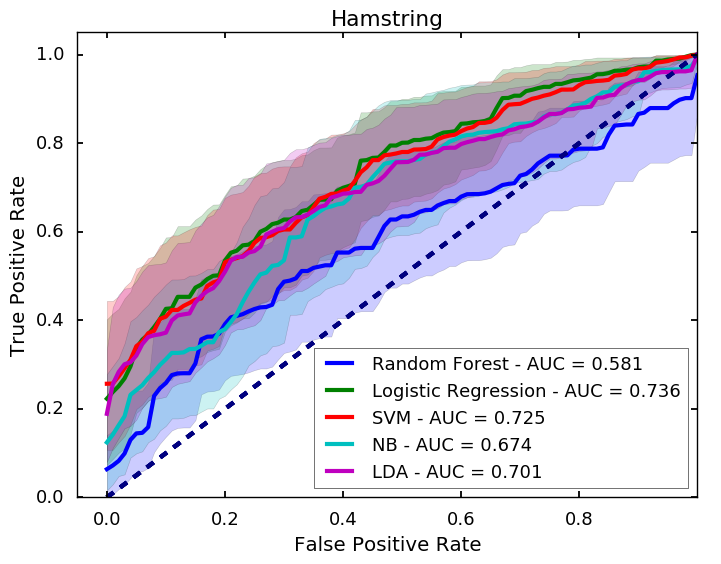

In [77]:
l = 'Hamstring'
c = 0
Labels = FullData.Label
plt.figure(figsize=(8,6))

FiltData = FullData.loc[(Labels!='IA') & (FullData.Location==l)]
for s in FiltData.SubjID.unique():
    if len(FiltData[FiltData.SubjID==s].Label.unique())<2:
        FiltData = FiltData[FiltData.SubjID!=s]
        
#randomly resample equal number of clips for all subjects
FiltDataR = pd.DataFrame(columns=FiltData.columns)
print(FiltDataR.shape)
nc0 = len(FiltData[(FiltData.SubjID==s) & (FiltData.Location=='Hamstring') & (FiltData.Label=='HA')])
nc1 = len(FiltData[(FiltData.SubjID==s) & (FiltData.Location=='Hamstring') & (FiltData.Label=='SA')])
nc0 = int(np.median(nc0))
nc1 = int(np.median(nc1)) #number of clips to resample per subject

print('Nclips Non-spastic = %d'%nc0)
print('Nclips Spastic = %d'%nc1)

for s in FiltData.SubjID.unique():
    idx = FiltData[(FiltData.SubjID==s) & (FiltData.Label=='SA')].index
    if len(idx) < nc1: #need resample with replacement
        newidx = np.random.choice(idx,nc1,replace=True)
    else:
        newidx = np.random.choice(idx,nc1,replace=False)
    FiltDataR = pd.concat([FiltDataR,FiltData.loc[newidx,:]])
    
    idx = FiltData[(FiltData.SubjID==s) & (FiltData.Label=='HA')].index
    if len(idx) < nc0: #need resample with replacement
        newidx = np.random.choice(idx,nc0,replace=True)
    else:
        newidx = np.random.choice(idx,nc0,replace=False)
    FiltDataR = pd.concat([FiltDataR,FiltData.loc[newidx,:]])


FiltData = FiltDataR
print(FiltData.shape)

Features = FiltData.iloc[:,0:14]
Features = Features.as_matrix()
SubjID = FiltData.SubjID
Label = FiltData.Label=='SA'
Location = FiltData.Location
        
#standardize data
scaler = preprocessing.StandardScaler().fit(Features) #define scaler on Healthy data
Features = scaler.transform(Features)
FiltData = pd.concat([pd.DataFrame(Features),
                      pd.DataFrame({'SubjID':SubjID.as_matrix(),'Label':Label.as_matrix(),'Location':Location.as_matrix()})],axis=1)
        
for clf,name in zip(models,model_name):
    print(name)
    results = LOSOCV(Features,Label.as_matrix(),FiltData,SubjID.as_matrix(),clf,0)

    AX = plot_roc(results['TPR'],results['FPR'],np.mean(results['AUC']),ax=None,plotname=name,col=current_palette[c])
    AX.set_title(l)
    c+=1 #switch color


In [79]:
len(FiltData.SubjID.unique())

15

## Use Stacking

In [85]:
models = [RandomForestClassifier(n_estimators=100,random_state=2),
          LogisticRegression(C=.001),
          SVC(kernel='linear',C=.001,cache_size=1600,probability=True,random_state=3),
          GaussianNB(),
          LinearDiscriminantAnalysis(),
         ]
model_name = ['Random Forest','Logistic Regression','SVM','NB','LDA']

(0, 20)
Nclips Non-spastic = 192
Nclips Spastic = 160
(5280, 20)
Random Forest
Logistic Regression
SVM
NB
LDA
base-level classifiers trained
training meta-classifier
best base-clf NB, auc = 0.924, worst base-clf Random Forest, minauc = 0.248
auc meta = 0.382

AUC = 0.3828, Sens = 0.3688, Spec = 0.7900

Random Forest
Logistic Regression
SVM
NB
LDA
base-level classifiers trained
training meta-classifier
best base-clf SVM, auc = 0.458, worst base-clf Random Forest, minauc = 0.412
auc meta = 0.415

AUC = 0.4138, Sens = 0.9062, Spec = 0.2300

Random Forest
Logistic Regression
SVM
NB
LDA
base-level classifiers trained
training meta-classifier
best base-clf NB, auc = 0.553, worst base-clf Random Forest, minauc = 0.379
auc meta = 0.567

AUC = 0.5673, Sens = 0.6625, Spec = 0.5800

Random Forest
Logistic Regression
SVM
NB
LDA
base-level classifiers trained
training meta-classifier
best base-clf SVM, auc = 0.806, worst base-clf NB, minauc = 0.184
auc meta = 0.635

AUC = 0.6362, Sens = 0.8375, Spe

/Users/luca/anaconda/envs/py35/lib/python3.5/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


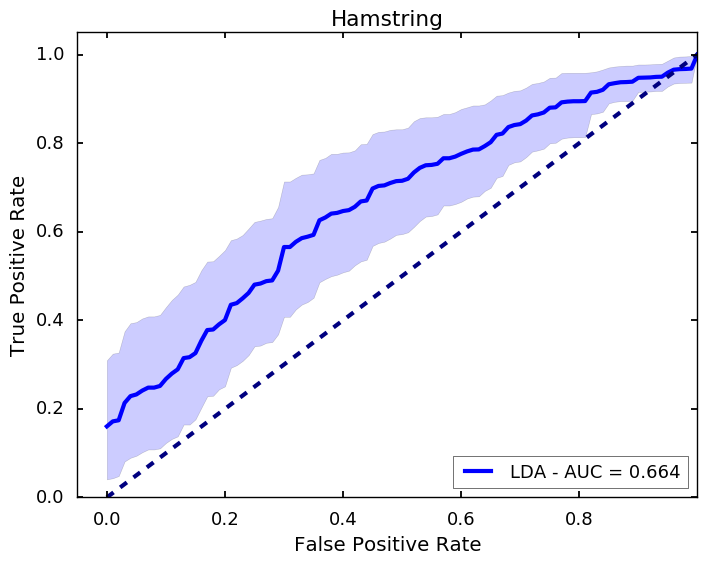

In [86]:
l = 'Hamstring'
c = 0
Labels = FullData.Label
plt.figure(figsize=(8,6))

FiltData = FullData.loc[(Labels!='IA') & (FullData.Location==l)]
for s in FiltData.SubjID.unique():
    if len(FiltData[FiltData.SubjID==s].Label.unique())<2:
        FiltData = FiltData[FiltData.SubjID!=s]
        
#randomly resample equal number of clips for all subjects
FiltDataR = pd.DataFrame(columns=FiltData.columns)
print(FiltDataR.shape)
nc0 = len(FiltData[(FiltData.SubjID==s) & (FiltData.Location=='Hamstring') & (FiltData.Label=='HA')])
nc1 = len(FiltData[(FiltData.SubjID==s) & (FiltData.Location=='Hamstring') & (FiltData.Label=='SA')])
nc0 = int(np.median(nc0))
nc1 = int(np.median(nc1)) #number of clips to resample per subject
print('Nclips Non-spastic = %d'%nc0)
print('Nclips Spastic = %d'%nc1)
for s in FiltData.SubjID.unique():
    idx = FiltData[(FiltData.SubjID==s) & (FiltData.Label=='SA')].index
    if len(idx) < nc1: #need resample with replacement
        newidx = np.random.choice(idx,nc1,replace=True)
    else:
        newidx = np.random.choice(idx,nc1,replace=False)
    FiltDataR = pd.concat([FiltDataR,FiltData.loc[newidx,:]])
    
    idx = FiltData[(FiltData.SubjID==s) & (FiltData.Label=='HA')].index
    if len(idx) < nc0: #need resample with replacement
        newidx = np.random.choice(idx,nc0,replace=True)
    else:
        newidx = np.random.choice(idx,nc0,replace=False)
    FiltDataR = pd.concat([FiltDataR,FiltData.loc[newidx,:]])
FiltData = FiltDataR
print(FiltData.shape)
               
Features = FiltData.iloc[:,0:14]
Features = Features.as_matrix()
SubjID = FiltData.SubjID
Label = FiltData.Label=='SA'
Location = FiltData.Location
        
#standardize data
scaler = preprocessing.StandardScaler().fit(Features) #define scaler on Healthy data
Features = scaler.transform(Features)
FiltData = pd.concat([pd.DataFrame(Features),
                      pd.DataFrame({'SubjID':SubjID.as_matrix(),'Label':Label.as_matrix(),'Location':Location.as_matrix()})],axis=1)
        
results = LOSOCV(Features,Label.as_matrix(),FiltData,SubjID.as_matrix(),models,1)

AX = plot_roc(results['TPR'],results['FPR'],np.mean(results['AUC']),ax=None,plotname=name,col=current_palette[c])
AX.set_title(l)


## Gastrocnemius

In [107]:
#Load Clips Data
# FullData = pd.read_csv(savepath+'Clips_ws0.5_overlap0.5.csv')
# FullData = pd.read_csv(savepath+'Clips_ws0.5_overlap0.8.csv')
FullData = pd.read_csv(savepath+'Clips_ws1.0_overlap0.5.csv')
# FullData = pd.read_csv(savepath+'Clips_ws1.0_overlap0.8.csv')

print (FullData.shape)

(2047, 20)


In [108]:
FullData.Location.unique()

array(['Gastrocnemius', 'Hamstring'], dtype=object)

(0, 20)
Nclips Non-spastic = 74
Nclips Spastic = 11
(510, 20)
Random Forest
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000

AUC = 0.8923, Sens = 1.0000, Spec = 0.8600

AUC = 0.8741, Sens = 1.0000, Spec = 0.6300

AUC = 0.0000, Sens = 0.0000, Spec = 1.0000

AUC = 0.4132, Sens = 0.6364, Spec = 0.3900

AUC = 0.6836, Sens = 0.5455, Spec = 0.9800

mean AUC = 0.644 (+/- 0.281)
mean Sens = 0.697 (+/- 0.296)
mean Spec = 0.810 (+/- 0.186)
Logistic Regression
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000

AUC = 0.0150, Sens = 1.0000, Spec = 0.0100



/Users/luca/anaconda/envs/py35/lib/python3.5/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


AUC = 0.9809, Sens = 1.0000, Spec = 0.8700

AUC = 0.3214, Sens = 1.0000, Spec = 0.1000

AUC = 0.4405, Sens = 0.4545, Spec = 0.6200

AUC = 0.7941, Sens = 1.0000, Spec = 0.6300

mean AUC = 0.592 (+/- 0.296)
mean Sens = 0.909 (+/- 0.166)
mean Spec = 0.538 (+/- 0.300)
SVM
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000

AUC = 0.2750, Sens = 1.0000, Spec = 0.2700

AUC = 0.9668, Sens = 0.9091, Spec = 1.0000

AUC = 0.9168, Sens = 1.0000, Spec = 0.8100

AUC = 0.4286, Sens = 0.0909, Spec = 0.9800

AUC = 0.8164, Sens = 0.7273, Spec = 0.7800

mean AUC = 0.734 (+/- 0.228)
mean Sens = 0.788 (+/- 0.266)
mean Spec = 0.807 (+/- 0.209)
NB
AUC = 0.2764, Sens = 0.2727, Spec = 1.0000

AUC = 0.0050, Sens = 0.0000, Spec = 1.0000

AUC = 0.9018, Sens = 0.9091, Spec = 0.9100

AUC = 0.1768, Sens = 0.0000, Spec = 1.0000

AUC = 0.4432, Sens = 0.6364, Spec = 0.4100

AUC = 0.7405, Sens = 1.0000, Spec = 0.6300

mean AUC = 0.424 (+/- 0.255)
mean Sens = 0.470 (+/- 0.330)
mean Spec = 0.825 (+/- 0.185)
LDA
AUC = 1.0000, Sens

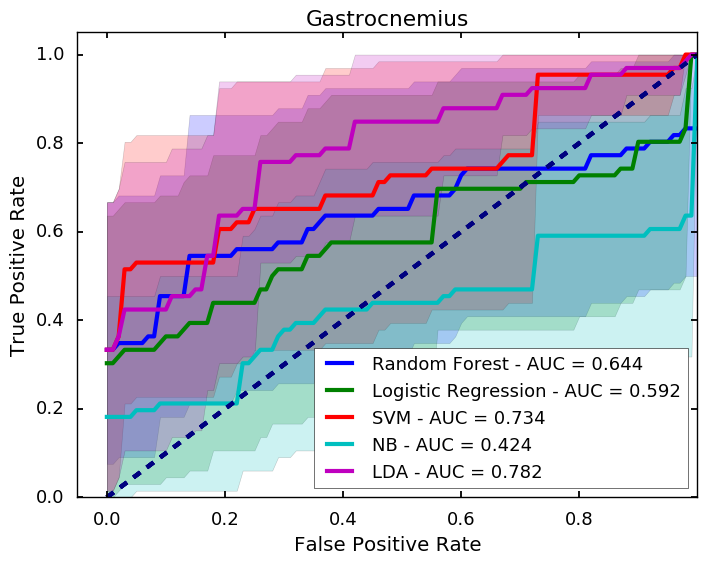

In [117]:
l = 'Gastrocnemius'
c = 0
Labels = FullData.Label
plt.figure(figsize=(8,6))

FiltData = FullData.loc[(Labels!='IA') & (FullData.Location==l)]
for s in FiltData.SubjID.unique():
    if len(FiltData[FiltData.SubjID==s].Label.unique())<2:
        FiltData = FiltData[FiltData.SubjID!=s]

#randomly resample equal number of clips for all subjects
FiltDataR = pd.DataFrame(columns=FiltData.columns)
print(FiltDataR.shape)
nc0 = len(FiltData[(FiltData.SubjID==s) & (FiltData.Location=='Gastrocnemius') & (FiltData.Label=='HA')])
nc1 = len(FiltData[(FiltData.SubjID==s) & (FiltData.Location=='Gastrocnemius') & (FiltData.Label=='SA')])
nc0 = int(np.max(nc0))
nc1 = int(np.max(nc1)) #number of clips to resample per subject

print('Nclips Non-spastic = %d'%nc0)
print('Nclips Spastic = %d'%nc1)

for s in FiltData.SubjID.unique():
    idx = FiltData[(FiltData.SubjID==s) & (FiltData.Label=='SA')].index
    if len(idx) < nc1: #need resample with replacement
        newidx = np.random.choice(idx,nc1,replace=True)
    else:
        newidx = np.random.choice(idx,nc1,replace=False)
    FiltDataR = pd.concat([FiltDataR,FiltData.loc[newidx,:]])
    
    idx = FiltData[(FiltData.SubjID==s) & (FiltData.Label=='HA')].index
    if len(idx) < nc0: #need resample with replacement
        newidx = np.random.choice(idx,nc0,replace=True)
    else:
        newidx = np.random.choice(idx,nc0,replace=False)
    FiltDataR = pd.concat([FiltDataR,FiltData.loc[newidx,:]])

FiltData = FiltDataR
print(FiltData.shape)
        
Features = FiltData.iloc[:,0:14]
Features = Features.as_matrix()
SubjID = FiltData.SubjID
Label = FiltData.Label=='SA'
Location = FiltData.Location
        
#standardize data
scaler = preprocessing.StandardScaler().fit(Features) #define scaler on Healthy data
Features = scaler.transform(Features)
FiltData = pd.concat([pd.DataFrame(Features),
                      pd.DataFrame({'SubjID':SubjID.as_matrix(),'Label':Label.as_matrix(),'Location':Location.as_matrix()})],axis=1)
        
for clf,name in zip(models,model_name):
    print(name)
    results = LOSOCV(Features,Label.as_matrix(),FiltData,SubjID.as_matrix(),clf,0)

    AX = plot_roc(results['TPR'],results['FPR'],np.mean(results['AUC']),ax=None,plotname=name,col=current_palette[c])
    AX.set_title(l)
    c+=1 #switch color


In [111]:
models = [RandomForestClassifier(n_estimators=200,random_state=2),
          LogisticRegression(C=.001),
          SVC(kernel='linear',C=.001,cache_size=1600,probability=True,random_state=3),
          GaussianNB(),
          LinearDiscriminantAnalysis()
         ]

In [112]:
FiltData.SubjID.unique()

array([  1.,   2.,  10.,  12.,  31.,  32.])

In [113]:
for s in FiltData.SubjID.unique():
    print(sum(SubjID==s))

85
85
85
85
85
85


## Use Stacking

(0, 20)
Nclips Non-spastic = 74
Nclips Spastic = 11
(510, 20)
Random Forest
Logistic Regression
SVM
NB
LDA
base-level classifiers trained
training meta-classifier
best base-clf Random Forest, auc = 1.000, worst base-clf NB, minauc = 0.509
auc meta = 1.000

AUC = 1.0000, Sens = 1.0000, Spec = 1.0000

Random Forest
Logistic Regression
SVM
NB
LDA
base-level classifiers trained
training meta-classifier
best base-clf Random Forest, auc = 0.765, worst base-clf NB, minauc = 0.000
auc meta = 0.193

AUC = 0.1932, Sens = 1.0000, Spec = 0.0800

Random Forest
Logistic Regression
SVM
NB
LDA
base-level classifiers trained
training meta-classifier
best base-clf SVM, auc = 0.998, worst base-clf Random Forest, minauc = 0.829
auc meta = 0.998

AUC = 0.9977, Sens = 1.0000, Spec = 0.9700

Random Forest
Logistic Regression
SVM
NB
LDA
base-level classifiers trained
training meta-classifier
best base-clf SVM, auc = 0.946, worst base-clf Random Forest, minauc = 0.138
auc meta = 0.940

AUC = 0.9368, Sens = 1.0

/Users/luca/anaconda/envs/py35/lib/python3.5/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


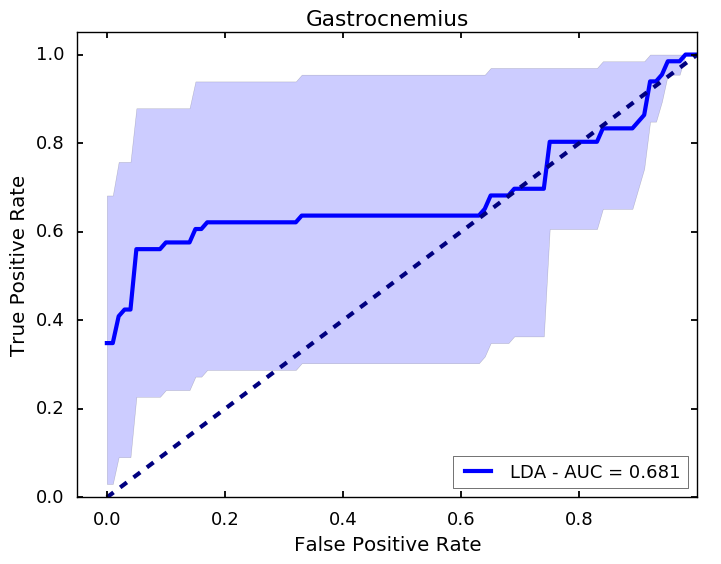

In [115]:
l = 'Gastrocnemius'
c = 0
Labels = FullData.Label
plt.figure(figsize=(8,6))

FiltData = FullData.loc[(Labels!='IA') & (FullData.Location==l)]
for s in FiltData.SubjID.unique():
    if len(FiltData[FiltData.SubjID==s].Label.unique())<2:
        FiltData = FiltData[FiltData.SubjID!=s]


#randomly resample equal number of clips for all subjects
FiltDataR = pd.DataFrame(columns=FiltData.columns)
print(FiltDataR.shape)
nc0 = len(FiltData[(FiltData.SubjID==s) & (FiltData.Location=='Gastrocnemius') & (FiltData.Label=='HA')])
nc1 = len(FiltData[(FiltData.SubjID==s) & (FiltData.Location=='Gastrocnemius') & (FiltData.Label=='SA')])
nc0 = int(np.max(nc0))
nc1 = int(np.max(nc1)) #number of clips to resample per subject

print('Nclips Non-spastic = %d'%nc0)
print('Nclips Spastic = %d'%nc1)

for s in FiltData.SubjID.unique():
    idx = FiltData[(FiltData.SubjID==s) & (FiltData.Label=='SA')].index
    if len(idx) < nc1: #need resample with replacement
        newidx = np.random.choice(idx,nc1,replace=True)
    else:
        newidx = np.random.choice(idx,nc1,replace=False)
    FiltDataR = pd.concat([FiltDataR,FiltData.loc[newidx,:]])
    
    idx = FiltData[(FiltData.SubjID==s) & (FiltData.Label=='HA')].index
    if len(idx) < nc0: #need resample with replacement
        newidx = np.random.choice(idx,nc0,replace=True)
    else:
        newidx = np.random.choice(idx,nc0,replace=False)
    FiltDataR = pd.concat([FiltDataR,FiltData.loc[newidx,:]])

FiltData = FiltDataR
print(FiltData.shape)

Features = FiltData.iloc[:,0:14]
Features = Features.as_matrix()
SubjID = FiltData.SubjID
Label = FiltData.Label=='SA'
Location = FiltData.Location
        
#standardize data
scaler = preprocessing.StandardScaler().fit(Features) #define scaler on Healthy data
Features = scaler.transform(Features)
FiltData = pd.concat([pd.DataFrame(Features),
                      pd.DataFrame({'SubjID':SubjID.as_matrix(),'Label':Label.as_matrix(),'Location':Location.as_matrix()})],axis=1)
        
results = LOSOCV(Features,Label.as_matrix(),FiltData,SubjID.as_matrix(),models,1)

AX = plot_roc(results['TPR'],results['FPR'],np.mean(results['AUC']),ax=None,plotname=model_name[-1],col=current_palette[c])
AX.set_title(l)
